In [4]:
%pip install imblearn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
    torch (>=1.7.*)
           ~~~~~~^
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [297]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')
import imblearn

import gausslink
import tqdm
import time

from scipy import signal

In [2]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']

har_df = pd.read_csv('./WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt',names = columns, on_bad_lines='skip')

# removing null values
har_df = har_df.dropna()
har_df.shape

# transforming the z-axis to float
har_df['z-axis'] = har_df['z-axis'].str.replace(';', '')
har_df['z-axis'] = har_df['z-axis'].apply(lambda x:float(x))

# drop the rows where timestamp is 0
df = har_df[har_df['timestamp'] != 0]

# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [5]:
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user']<28]
# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user']>27]

df_test.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
792622,28,Walking,1506362316000,-0.08,7.40,3.173541
792623,28,Walking,1506412243000,-0.04,8.62,2.873893
792624,28,Walking,1506462292000,0.69,9.53,4.181447
792625,28,Walking,1506512249000,-0.76,8.92,4.140586
792626,28,Walking,1506562328000,-1.57,8.58,3.636633


## Magnitude, pitch, roll

Add features to dataframe based on xyz

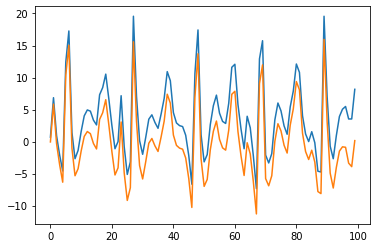

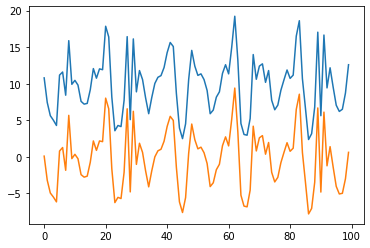

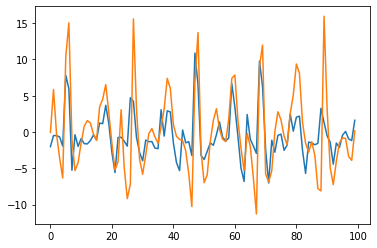

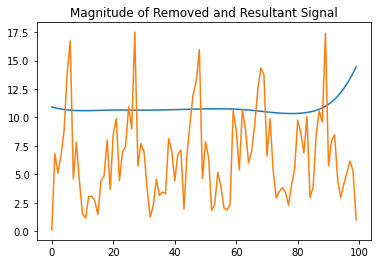

In [209]:
import numpy as np
from scipy.signal import butter, filtfilt

def highpass_filter(data, cutoff_freq, sampling_rate, order=10):
    """
    Applies a low-pass filter to the given data.

    Args:
        data (array-like): The input data to be filtered.
        cutoff_freq (float): The cutoff frequency of the filter in Hz.
        sampling_rate (float): The sampling rate of the data in Hz.
        order (int, optional): The order of the filter. Higher order filters 
                                have a sharper cutoff but can introduce more 
                                artifacts. Defaults to 2.

    Returns:
        numpy.ndarray: The filtered data.
    """
    nyquist_rate = 0.5 * sampling_rate
    normalized_cutoff = cutoff_freq / nyquist_rate
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

start=0
end =100

datax = df_train['x-axis'][start:end]
datay = df_train['y-axis'][start:end]
dataz = df_train['z-axis'][start:end]

filtered_signalx = highpass_filter(datax, cutoff_freq, sampling_rate)
filtered_signaly = highpass_filter(datay, cutoff_freq, sampling_rate)
filtered_signalz = highpass_filter(dataz, cutoff_freq, sampling_rate)

# Generate sample data 
sampling_rate = 50  # Hz
duration = 2  # seconds
time = np.arange(start, end, 1)

# Signal with 2 frequencies
    
cutoff_freq = 0.5 # Hz

plt.figure()
plt.plot(datax)
plt.plot(time, filtered_signalx)

plt.figure()
plt.plot(datay)
plt.plot(time,filtered_signaly)

plt.figure()
plt.plot(dataz)
plt.plot(time,filtered_signalx)

plt.figure()
plt.title("Magnitude of Removed and Resultant Signal")
plt.plot(time,np.sqrt((datax-filtered_signalx)**2 + (datay-filtered_signaly)**2+(dataz-filtered_signalz)**2))
plt.plot(time,np.sqrt((filtered_signalx)**2 + (filtered_signaly)**2+(filtered_signalz)**2))






In [18]:
df_train['magnitude']=np.sqrt(df_train['x-axis']**2 + df_train['y-axis']**2 + df_train['z-axis']**2)
df_test['magnitude']=np.sqrt(df_test['x-axis']**2 + df_test['y-axis']**2 + df_test['z-axis']**2)

In [27]:
df_train.query("magnitude > 9.75 and magnitude <9.85 and activity=='Standing'")

,user,activity,timestamp,x-axis,y-axis,z-axis,magnitude
79105,3,Standing,102539961524000,-0.76,9.62,1.460000,9.759795
79281,3,Standing,102548761603000,-0.95,9.72,-0.380000,9.773705
79754,3,Standing,102572421485000,-1.14,9.72,0.150000,9.787773
80478,3,Standing,102608621558000,-0.65,9.77,-0.080000,9.791925
80481,3,Standing,102608741523000,-1.18,9.70,-0.110000,9.772129
...,...,...,...,...,...,...,...
792569,27,Standing,12614712812000,0.31,9.70,-1.498238,9.819919
792583,27,Standing,12615412854000,0.34,9.70,-1.457377,9.814762
792599,27,Standing,12616212842000,0.80,9.66,-1.525479,9.812374
792605,27,Standing,12616512860000,0.08,9.70,-1.375655,9.797389


Downsample Bigger Classes!

In [212]:
df_train['activity'].unique()

array(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [512]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()
x_list = []
y_list = []
z_list = []
x0_list = []
y0_list = []
z0_list = []
mag_list = []
grav_list = []
train_labels = []

window_size = 150 #3s
step_size = 50 #1s
ds=2

user_list = df_train.user.unique()
activity_list = df_train.activity.unique()

cutoff_freq = 0.5
sampling_rate = 50
highpass = True

for j in user_list:
    for k in activity_list:
        df_sub = df_train.query(f"activity=='{k}'").query(f"user=={j}")
        df_sub=df_sub.reset_index()
        if df_sub.shape[0]>50:
            df_sub['x-axis0'] = df_sub['x-axis']
            df_sub['y-axis0'] = df_sub['y-axis']
            df_sub['z-axis0'] = df_sub['z-axis']
            if highpass:
                df_sub['x-axis'] = highpass_filter(df_sub['x-axis'], cutoff_freq, sampling_rate)
                df_sub['y-axis'] = highpass_filter(df_sub['y-axis'], cutoff_freq, sampling_rate)
                df_sub['z-axis'] = highpass_filter(df_sub['z-axis'], cutoff_freq, sampling_rate)
        #df_train.query("activity=='Walking'").query("user==1")
        for i in range(0, df_sub.shape[0] - window_size, step_size):
            if highpass:
                x0s = df_sub['x-axis0'].values[i: i + window_size]
                x0s = signal.decimate(x0s,ds)
                
                y0s = df_sub['y-axis0'].values[i: i + window_size]
                y0s = signal.decimate(y0s,ds)
                
                z0s = df_sub['z-axis0'].values[i: i + window_size]
                z0s = signal.decimate(z0s,ds)
                
            xs = df_sub['x-axis'].values[i: i + window_size]
            xs = signal.decimate(xs,ds)
            
            ys = df_sub['y-axis'].values[i: i + window_size]
            ys = signal.decimate(ys,ds)
            
            zs = df_sub['z-axis'].values[i: i + window_size]
            zs = signal.decimate(zs,ds)
            
            mags=np.sqrt(xs**2 + ys**2 + zs**2)
            grav = np.sqrt((df_sub['x-axis']-df_sub['x-axis0'])**2 +
            (df_sub['y-axis']-df_sub['y-axis0'])**2 +
            (df_sub['z-axis']-df_sub['z-axis0'])**2)
            #mags = signal.decimate(mags,ds)
            
            label = df_sub['activity'][i: i + window_size][i]

            x_list.append(xs)
            y_list.append(ys)
            z_list.append(zs)
            x0_list.append(x0s)
            y0_list.append(y0s)
            z0_list.append(z0s)
            
            mag_list.append(mags)
            grav_list.append(grav)
            train_labels.append(label)
            
Xtr = list(zip(x_list, y_list, z_list, x0_list, y0_list, z0_list, mag_list))

In [513]:
len(Xtr)

15530

In [310]:
# creating features from windows

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())
X_train['mag_mean'] = pd.Series(mag_list).apply(lambda x: x.mean())
X_train['grav_mean'] = pd.Series(grav_list).apply(lambda x: x.mean())
# magmean

# argmin 
X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: x.argmin())
X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: x.argmin())
X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: x.argmin())
X_train['mag_argmin'] = pd.Series(mag_list).apply(lambda x: x.argmin())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())
X_train['mag_std'] = pd.Series(mag_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['mag_aad'] = pd.Series(mag_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))


# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())
X_train['mag_min'] = pd.Series(mag_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())
X_train['mag_max'] = pd.Series(mag_list).apply(lambda x: x.max())

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))
X_train['mag_skewness'] = pd.Series(mag_list).apply(lambda x: stats.skew(x))



In [119]:
y_train = train_labels

In [218]:
wr = []
for i in  tqdm.tqdm(range(len(x_list))):
    xs = x_list[i]
    ys = y_list[i]
    zs = z_list[i]
    xyz = np.array([xs,ys,zs])
    coords = np.swapaxes(xyz,0,1)
    writhe = gausslink.linkage_integral(coords,coords)
    wr.append(writhe)
    
X_train['writhe']=wr


100%|█████████████████████████████████████| 15790/15790 [06:48<00:00, 38.66it/s]


In [ ]:
walkingTF = [i for i, string in enumerate(train_labels) if string=='Walking']
joggingTF = [i=='Jogging' for i in train_labels]

In [ ]:
wr_max = []
for i in  tqdm.tqdm(range(len(x_list))):
    xs = x_list[i]
    ys = y_list[i]
    zs = z_list[i]
    xyz = np.array([xs,ys,zs])
    coords = np.swapaxes(xyz,0,1)
    writhe_max = linkage_max(coords,coords)
    wr_max.append(writhe_max)
    
X_train['writhe_max']=wr_max


In [ ]:
# converting the signals from time domain to frequency domain using FFT
wds= len(x_list[0])
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
#X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [182]:
X_train.to_csv("X_fulltrain_downsampled_highpassFILT"+str(window_size)+"_"+str(step_size)+".csv")

### Create test dataframe


In [311]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [ ]:
df_test.head()

In [222]:
#df_test = df_test.drop('level_0',axis=1)

In [514]:
#df_test= df_test.reset_index()
user_list = df_test.user.unique()
x_list = []
y_list = []
z_list = []
x0_list = []
y0_list = []
z0_list = []
mag_list = []
grav_list =[]
test_labels = []

window_size = 150
step_size = 50

for j in user_list:
    for k in activity_list:
        df_sub = df_test.query(f"activity=='{k}'").query(f"user=={j}")
        df_sub=df_sub.reset_index()
        #print(k, j, df_sub.shape)
        if df_sub.shape[0]>50:
            df_sub['x-axis0'] = df_sub['x-axis']
            df_sub['y-axis0'] = df_sub['y-axis']
            df_sub['z-axis0'] = df_sub['z-axis']
            if highpass:
                df_sub['x-axis'] = highpass_filter(df_sub['x-axis'], cutoff_freq, sampling_rate)
                df_sub['y-axis'] = highpass_filter(df_sub['y-axis'], cutoff_freq, sampling_rate)
                df_sub['z-axis'] = highpass_filter(df_sub['z-axis'], cutoff_freq, sampling_rate)

        #df_train.query("activity=='Walking'").query("user==1")
        for i in range(0, df_sub.shape[0] - window_size, step_size):
            if highpass:
                x0s = df_sub['x-axis0'].values[i: i + window_size]
                x0s = signal.decimate(x0s,ds)
                
                y0s = df_sub['y-axis0'].values[i: i + window_size]
                y0s = signal.decimate(y0s,ds)
                
                z0s = df_sub['z-axis0'].values[i: i + window_size]
                z0s = signal.decimate(z0s,ds)
              
            xs = df_sub['x-axis'].values[i: i + window_size]
            xs = signal.decimate(xs,ds)
            
            ys = df_sub['y-axis'].values[i: i + window_size]
            ys = signal.decimate(ys,ds)
            
            zs = df_sub['z-axis'].values[i: i + window_size]
            zs = signal.decimate(zs,ds)
            
            mags=np.sqrt(xs**2 + ys**2 + zs**2)
            
            grav = np.sqrt((df_sub['x-axis']-df_sub['x-axis0'])**2 +
            (df_sub['y-axis']-df_sub['y-axis0'])**2 +
            (df_sub['z-axis']-df_sub['z-axis0'])**2)
            
            label = df_sub['activity'][i: i + window_size][i]

            x_list.append(xs)
            y_list.append(ys)
            z_list.append(zs)
            x0_list.append(x0s)
            y0_list.append(y0s)
            z0_list.append(z0s)
            mag_list.append(mags)
            grav_list.append(grav)
            test_labels.append(label)


In [515]:
Xte = list(zip(x_list, y_list, z_list, x0_list, y0_list, z0_list, mag_list))
len(Xte)

5495

In [313]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())
X_test['mag_mean'] = pd.Series(mag_list).apply(lambda x: x.mean())
X_test['grav_mean'] = pd.Series(grav_list).apply(lambda x: x.mean())


# argmin 
X_test['x_argmin'] = pd.Series(x_list).apply(lambda x: x.argmin())
X_test['y_argmin'] = pd.Series(y_list).apply(lambda x: x.argmin())
X_test['z_argmin'] = pd.Series(z_list).apply(lambda x: x.argmin())
X_test['mag_argmin'] = pd.Series(mag_list).apply(lambda x: x.argmin())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())
X_test['mag_std'] = pd.Series(mag_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['mag_aad'] = pd.Series(mag_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))


# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())
X_test['mag_min'] = pd.Series(mag_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())
X_test['mag_max'] = pd.Series(mag_list).apply(lambda x: x.max())
X_test['grav_max'] = pd.Series(grav_list).apply(lambda x: x.max())

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))
X_test['mag_skewness'] = pd.Series(mag_list).apply(lambda x: stats.skew(x))


10.769752512021658

In [88]:
wr = []
#wr_max = []
for i in tqdm.tqdm(range(len(x_list))):
    xs = x_list[i]
    ys = y_list[i]
    zs = z_list[i]
    xyz = np.array([xs,ys,zs])
    coords = np.swapaxes(xyz,0,1)
    writhe = gausslink.linkage_integral(coords,coords)
    #writhe_max = linkage_max(coords,coords)
    wr.append(writhe)
    #wr_max.append(writhe_max)

X_test["writhe"]=wr
#X_test['writhe_max']=wr_max

100%|███████████████████████████████████████| 5593/5593 [02:35<00:00, 36.08it/s]


In [89]:
X_train['abs_writhe']=np.abs(X_train["writhe"])
X_test['abs_writhe']=np.abs(X_test["writhe"])

X_train['log_writhe']=np.log10(X_train['abs_writhe'])
X_test['log_writhe']=np.log10(X_test['abs_writhe'])

In [175]:
wds = 50 

# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:wds+1])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())


# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
#X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

In [122]:
X_test['mean_aad']=(X_test['x_aad']+X_test['y_aad']+X_test['z_aad'])/3
X_train['mean_aad']=(X_train['x_aad']+X_train['y_aad']+X_train['z_aad'])/3

In [349]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

## Under/Over Sampling 

In [278]:
X_train=X_train_y

,x_mean,y_mean,z_mean,mag_mean,x_argmin,y_argmin,z_argmin,mag_argmin,x_std,y_std,...,mag_max,x_skewness,y_skewness,z_skewness,mag_skewness,writhe,abs_writhe,log_writhe,y_train,user
0,0.680149,-0.276499,0.604482,5.336098,22,12,15,0,4.297417,3.416470,...,10.724214,0.292639,-0.319312,0.237260,-0.071991,-76.065798,76.065798,1.881189,Walking,1
1,-0.460315,-0.100363,-0.293172,5.472234,11,18,11,22,4.413713,3.492008,...,10.604982,0.018148,-0.288933,0.232008,0.120250,714.634158,714.634158,2.854084,Walking,1
2,0.229178,0.366958,-0.057174,5.811668,7,3,24,20,4.600953,3.764024,...,10.612032,0.291689,-0.456470,0.472303,0.024094,128.530300,128.530300,2.109006,Walking,1
3,-0.291731,-0.080267,-0.034576,5.901594,13,10,19,5,4.816101,3.795644,...,10.833430,-0.174332,-0.587937,0.213665,0.337146,-87.519252,87.519252,1.942104,Walking,1
4,0.584484,0.004892,0.263112,5.869439,19,16,15,22,4.428475,3.848437,...,11.906145,-0.013895,-0.500930,0.283894,0.079651,60.848025,60.848025,1.784246,Walking,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15785,-0.007346,0.011165,0.046427,0.115394,3,0,16,13,0.089721,0.044694,...,0.342271,0.370405,-2.399390,0.590298,1.478262,-6.179056,6.179056,0.790922,Standing,27
15786,0.034938,-0.015952,0.009937,0.328842,4,21,5,14,0.274850,0.115356,...,0.733894,-0.387912,0.814149,0.089714,0.504224,86.509249,86.509249,1.937063,Standing,27
15787,-0.051725,0.031288,0.033135,0.462991,12,8,12,9,0.462720,0.132344,...,1.372528,0.190073,-0.203249,0.568981,1.342401,144.776452,144.776452,2.160698,Standing,27
15788,0.044025,-0.016448,-0.020693,0.429535,21,17,13,15,0.364775,0.108671,...,1.328962,0.241847,0.799485,0.706782,1.939285,-107.096113,107.096113,2.029774,Standing,27


In [351]:
# Test undersampler
X_test_rus, y_test_rus = rus.fit_resample(X_test, y_test)
pd.DataFrame(y_test_rus).value_counts()

0         
Downstairs    103
Jogging       103
Sitting       103
Standing      103
Upstairs      103
Walking       103
Name: count, dtype: int64

In [338]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

pd.DataFrame(y_res).value_counts()

0         
Downstairs    208
Jogging       208
Sitting       208
Standing      208
Upstairs      208
Walking       208
Name: count, dtype: int64

In [ ]:
#X_train['y_train']=train_labels

## Train Models

In [354]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# standardization
columns = X_train.columns

scaler = StandardScaler()
scaler.fit(X_res[columns])
X_train_data_lr = scaler.transform(X_res[columns])
X_test_data_lr = scaler.transform(X_test[columns])
X_test_rus_lr = scaler.transform(X_test_rus[columns])

# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_res)
y_pred_lr = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred_lr))

Accuracy: 0.775974025974026

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.54      0.78      0.64       187
     Jogging       0.86      0.88      0.87       503
     Sitting       0.67      0.73      0.70       116
    Standing       0.61      0.59      0.60       103
    Upstairs       0.56      0.43      0.48       210
     Walking       0.91      0.84      0.87       729

    accuracy                           0.78      1848
   macro avg       0.69      0.71      0.69      1848
weighted avg       0.78      0.78      0.78      1848



In [340]:
y_pred_lr = lr.predict(X_train_data_lr)
accuracy = accuracy_score(y_res, y_pred_lr)
print("Train Accuracy:", accuracy)

y_pred_lr = lr.predict(X_test_data_lr)
accuracy = accuracy_score(y_test, y_pred_lr)
print("Test Accuracy:", accuracy)

Train Accuracy: 0.7908653846153846
Test Accuracy: 0.775974025974026


In [341]:
# Get the coefficients
coefficients = lr.coef_[0]

# Create a dataframe to display the coefficients
feature_importance = pd.DataFrame({'feature': columns, 'coefficient': coefficients})

# Sort the dataframe by the absolute value of the coefficients
feature_importance = feature_importance.sort_values('coefficient', key=abs, ascending=False)

print(feature_importance)

         feature  coefficient
16       mag_aad    -1.667042
19         z_min    -1.656922
18         y_min    -1.590151
12       mag_std    -1.145627
22         y_max     0.924705
21         x_max     0.877341
14         y_aad     0.651661
17         x_min    -0.580170
11         z_std    -0.563077
15         z_aad     0.493548
26    y_skewness     0.445430
24       mag_max     0.300550
13         x_aad     0.266295
9          x_std    -0.207843
0         x_mean    -0.180153
5       x_argmin    -0.162543
7       z_argmin    -0.146226
1         y_mean    -0.139972
2         z_mean     0.124026
4      grav_mean     0.121742
28  mag_skewness    -0.121714
3       mag_mean    -0.084762
10         y_std     0.084482
25    x_skewness    -0.084301
23         z_max     0.056848
20       mag_min    -0.049681
27    z_skewness     0.036350
6       y_argmin    -0.032557
8     mag_argmin    -0.031368


In [320]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [288]:
len(test_labels)

5593

In [342]:
# Initialise and fit model
rf = RandomForestClassifier(max_depth=10)
rf.fit(X_train_data_lr, y_res)

y_pred_rf = rf.predict(X_train_data_lr)
accuracy = accuracy_score(y_res, y_pred_rf)
print("Train Accuracy:", round(accuracy,4))


y_pred_rf = rf.predict(X_test_data_lr)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Test Accuracy:", round(accuracy,4))

Train Accuracy: 0.9904
Test Accuracy: 0.6742


In [346]:
X_test_rus.shape

(618, 30)

In [358]:
# Initialise and fit model
rf = RandomForestClassifier()
rf.fit(X_train_data_lr, y_res)

y_pred_rf = rf.predict(X_train_data_lr)
accuracy = accuracy_score(y_res, y_pred_rf)
print("Train Accuracy:", round(accuracy,4))


y_pred_rf = rf.predict(X_test_data_lr)
accuracy = accuracy_score(y_test, y_pred_rf)
print("Unbalanced Test Accuracy:", round(accuracy,4))

y_pred_rf_rus = rf.predict(X_test_rus_lr)
accuracy = accuracy_score(y_test_rus, y_pred_rf_rus)
print("Balanced Test Accuracy:", round(accuracy,4))

print(classification_report(y_test_rus, y_pred_rf_rus))

Train Accuracy: 1.0
Unbalanced Test Accuracy: 0.6737
Balanced Test Accuracy: 0.6942
              precision    recall  f1-score   support

  Downstairs       0.55      0.60      0.57       103
     Jogging       0.86      0.87      0.87       103
     Sitting       0.75      0.93      0.83       103
    Standing       0.91      0.70      0.79       103
    Upstairs       0.52      0.61      0.56       103
     Walking       0.65      0.45      0.53       103

    accuracy                           0.69       618
   macro avg       0.71      0.69      0.69       618
weighted avg       0.71      0.69      0.69       618



In [332]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.2721861471861472
Precision: 0.07408529872003898
Recall: 0.2721861471861472


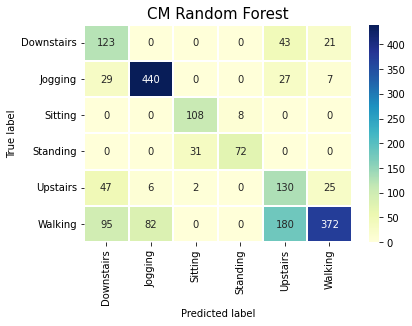

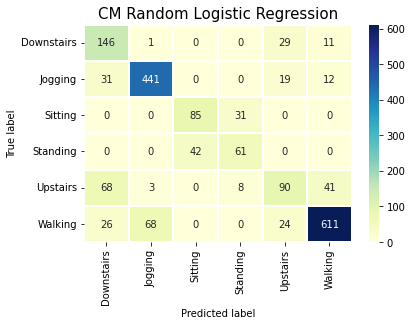

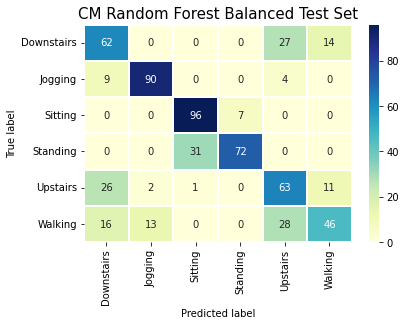

In [359]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('CM Random Forest', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

cm = confusion_matrix(y_test, y_pred_lr)
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('CM Random Logistic Regression', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


cm = confusion_matrix(y_test_rus, y_pred_rf_rus)
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('CM Random Forest Balanced Test Set', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


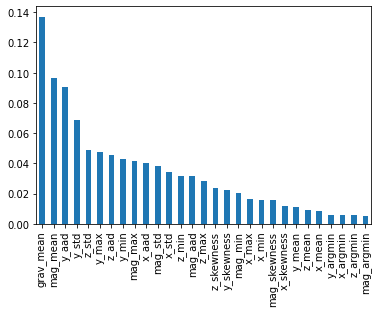

In [294]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [131]:
X_train.columns

Index(['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'x_aad',
       'y_aad', 'z_aad', 'x_min', 'y_min', 'z_min', 'x_max', 'y_max', 'z_max',
       'x_skewness', 'y_skewness', 'z_skewness', 'writhe', 'x_mean_fft',
       'y_mean_fft', 'z_mean_fft', 'x_std_fft', 'y_std_fft', 'z_std_fft',
       'x_aad_fft', 'y_aad_fft', 'z_aad_fft', 'x_min_fft', 'y_min_fft',
       'z_min_fft', 'x_peak_count_fft', 'y_peak_count_fft', 'z_peak_count_fft',
       'x_skewness_fft', 'y_skewness_fft', 'z_skewness_fft', 'x_kurtosis_fft',
       'y_kurtosis_fft', 'z_kurtosis_fft', 'x_energy_fft', 'y_energy_fft',
       'z_energy_fft', 'sma_fft', 'abs_writhe', 'log_writhe', 'y_train',
       'mean_aad'],
      dtype='object')

## Feature Correlation 

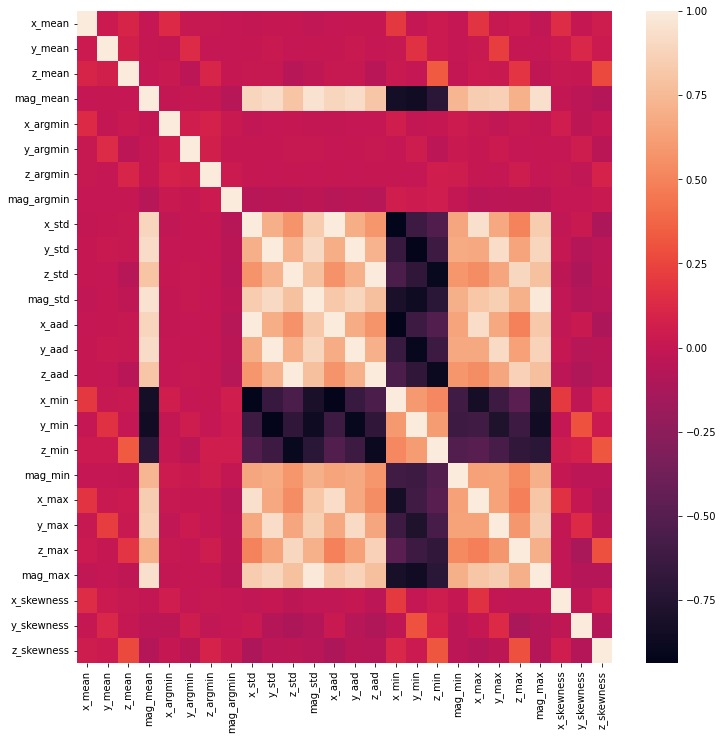

In [146]:
plt.figure(figsize=(12, 12))

corr_m = X_train.corr()
sns.heatmap(corr_m)
plt.show()

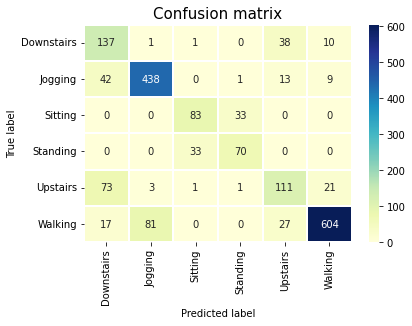

In [337]:
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
confusion_matrix = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('Confusion matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Writhe features by activity

In [100]:
X_test['writhe']=np.abs(X_test['writhe'])

In [241]:
X_train['abs_writhe']=np.abs(X_train['writhe'])
X_train['log_writhe'] = np.log10(X_train['abs_writhe'])
#X_train['log_writhe_mean'] = np.log10(X_train['writhe_mean'])
#X_train['writhe_mean']=X_train['abs_writhe']*np.abs(X_train['x_max'])

In [242]:
#X_train['logmax_writhe']=np.log10(X_train['writhe_max'])

In [ ]:
X_train['logmaxwr_mean']=X_train['logmax_writhe']/np.abs(X_train['x_max'])

In [299]:
X_train_y=X_train
X_train_y['y_train']=y_train
X_train_y['user']=users
X_train_y['grav']=X_train['grav_mean']

In [ ]:
X_train_y.columns

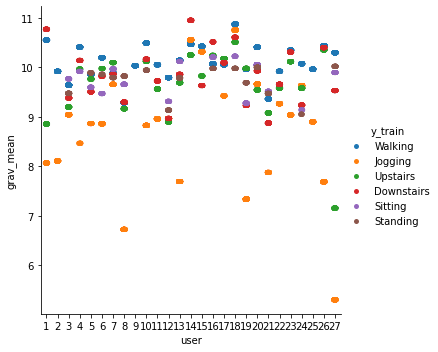

In [305]:
import seaborn as sns
sns.catplot(data=X_train_y, hue="y_train", y='grav_mean', x='user')

<Axes: title={'center': 'abs_writhe'}, xlabel='y_train'>

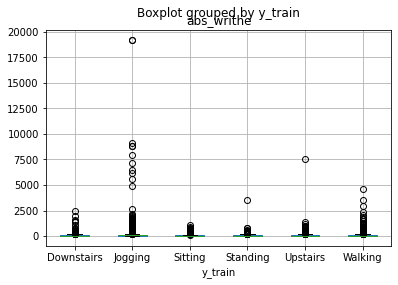

In [106]:
X_train['abs_writhe'] = np.abs(X_train['writhe'])
X_train.boxplot(column='abs_writhe',by='y_train')

In [ ]:
X_train.boxplot(column='writhe_mean',by='y_train')

In [ ]:
X_train.boxplot(column='log_writhe',by='y_train')

<Axes: title={'center': 'writhe'}, xlabel='y_train'>

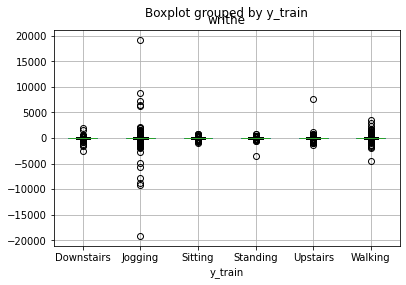

In [108]:
X_train.boxplot(column='writhe',by='y_train')

In [439]:
X_train.boxplot(column='x_mean',by='y_train')

KeyError: 'y_train'

## LSTM Version

In [362]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2025-02-13 21:59:12.635459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [506]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(np.array(train_labels))
onehot_trainlb = lb.transform(np.array(train_labels))

In [503]:
len(Xte)

5495

In [504]:
len(Xtr)

15530

In [505]:
len(train_labels)

15530

In [373]:
#XXtr = list(zip(Xtr[0], Xtr[1], Xtr[2]))
#XXte = list(zip(Xte[0], Xte[1], Xte[2]))

In [ ]:
rus

In [441]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense

In [530]:
# design network

XT = np.array(Xte)
XT = np.reshape(XT, (XT.shape[0],XT.shape[1],  XT.shape[2]))

X = np.array(Xtr)
X = np.reshape(X, (X.shape[0], X.shape[1],  X.shape[2]))


model = Sequential()
# Build the LSTM model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=6, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
#model.add(Dense(18, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, onehot_trainlb, epochs=20, batch_size=50, validation_freq=10)


Epoch 1/20
311/311 [==============================] - 4s 4ms/step - loss: 0.0548
Epoch 2/20
311/311 [==============================] - 1s 3ms/step - loss: 0.0386
Epoch 3/20
311/311 [==============================] - 1s 3ms/step - loss: 0.0332
Epoch 4/20
311/311 [==============================] - 1s 4ms/step - loss: 0.0289
Epoch 5/20
311/311 [==============================] - 1s 4ms/step - loss: 0.0257
Epoch 6/20
311/311 [==============================] - 1s 4ms/step - loss: 0.0231
Epoch 7/20
311/311 [==============================] - 1s 4ms/step - loss: 0.0209
Epoch 8/20
311/311 [==============================] - 1s 4ms/step - loss: 0.0182
Epoch 9/20
311/311 [==============================] - 1s 4ms/step - loss: 0.0161
Epoch 10/20
311/311 [==============================] - 1s 3ms/step - loss: 0.0152
Epoch 11/20
311/311 [==============================] - 1s 3ms/step - loss: 0.0129
Epoch 12/20
311/311 [==============================] - 1s 4ms/step - loss: 0.0124
Epoch 13/20
311/311 [====

In [531]:
# Make predictions
predictions = model.predict(XT)
#print(predictions)

172/172 [==============================] - 1s 2ms/step


In [532]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(lb.inverse_transform(predictions), test_labels)

print(classification_report(test_labels, lb.inverse_transform(predictions)))

              precision    recall  f1-score   support

  Downstairs       0.37      0.39      0.38       556
     Jogging       0.81      0.84      0.82      1503
     Sitting       0.88      0.91      0.89       339
    Standing       1.00      0.80      0.89       302
    Upstairs       0.34      0.63      0.45       618
     Walking       0.90      0.67      0.77      2177

    accuracy                           0.71      5495
   macro avg       0.72      0.71      0.70      5495
weighted avg       0.76      0.71      0.72      5495



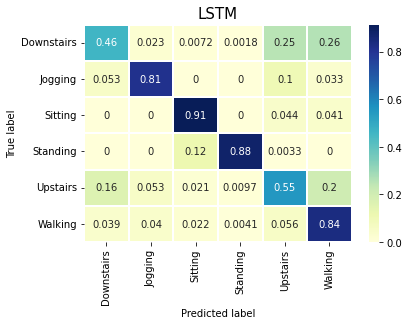

In [519]:
cm = confusion_matrix(test_labels, lb.inverse_transform(predictions), normalize='true')
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, cmap = 'YlGnBu')
plt.title('LSTM', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [433]:
metrics.f1_score(test_labels, lb.inverse_transform(predictions), average='weighted')

0.8132344019066925

In [434]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
xl_res, test_lab = rus.fit_resample(x_list, test_labels)

In [435]:
ros = RandomOverSampler(random_state=42)
yl_res, test_laby = rus.fit_resample(y_list, test_labels)

In [436]:
ros = RandomOverSampler(random_state=42)
zl_res, test_labz = rus.fit_resample(z_list, test_labels)

In [437]:
xtest_res = list(zip(xl_res, yl_res, zl_res))
Xtestres = np.array(xtest_res)
Xtestres = np.reshape(Xtestres, (Xtestres.shape[0],Xtestres.shape[1],  Xtestres.shape[2]))
predictions = model.predict(Xtestres)


20/20 [==============================] - 0s 1ms/step


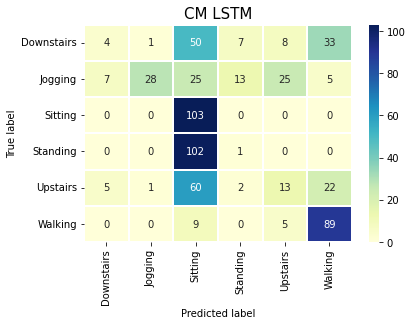

In [438]:

cm = confusion_matrix(test_lab, lb.inverse_transform(predictions))
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt='d', cmap = 'YlGnBu')
plt.title('CM LSTM', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [252]:
user_list

array([28, 29, 30, 31, 32, 33, 34, 35, 36])

In [253]:
user_list = df_train.user.unique()
activity_list = df_train.activity.unique()

for j in user_list:
    for k in activity_list:
        df_sub = df_train.query(f"activity=='{k}'").query(f"user=={j}")
        df_sub=df_sub.reset_index()
        if df_sub.shape[0]>50:
            df_sub['x-axis'] = highpass_filter(df_sub['x-axis'], cutoff_freq, sampling_rate)
            df_sub['y-axis'] = highpass_filter(df_sub['y-axis'], cutoff_freq, sampling_rate)
            df_sub['z-axis'] = highpass_filter(df_sub['z-axis'], cutoff_freq, sampling_rate)
        #df_train.query("activity=='Walking'").query("user==1")
        for i in range(0, df_sub.shape[0] - window_size, step_size):
            users.append(j)

In [254]:
users

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
